# Absolute vs relative
So far in my strategy, I've simply been looking at the historical absolute values of each player's stats. e.g. how many times Giannis Antetokounmpo scored more than 27.5 points.

Whilst working so far, I suspect that this may not be the best stat to look at, since it doesn't take into account the opponent. I want to first look at the variance in the proportion of the team's total statistic each player contributes for points, rebounds, and assits.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import pandas as pd
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [2]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

In [3]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

In [4]:
df_games = nba_stats.get_games()
df_games.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,PTS,HOME_AWAY,OPP_TEAM_ABBREVIATION,OPP_TEAM_ID,OPP_PTS
0,2018-19,1610612738,BOS,0021800001,2018-10-16T00:00:00,BOS vs. PHI,W,105,HOME,PHI,1610612755,87
1,2018-19,1610612744,GSW,0021800002,2018-10-16T00:00:00,GSW vs. OKC,W,108,HOME,OKC,1610612760,100
2,2018-19,1610612760,OKC,0021800002,2018-10-16T00:00:00,OKC @ GSW,L,100,AWAY,GSW,1610612744,108
3,2018-19,1610612755,PHI,0021800001,2018-10-16T00:00:00,PHI @ BOS,L,87,AWAY,BOS,1610612738,105
0,2018-19,1610612763,MEM,0021800005,2018-10-17T00:00:00,MEM @ IND,L,83,AWAY,IND,1610612754,111


In [16]:
player_name = 'Stephen Curry'
player_id = nba_stats.get_player_name_id_dict()[player_name]
df_player = player_df_convert_numeric(nba_stats.get_player_stats()[player_id].copy())
df_player = df_player[df_player['MIN'] > 0]

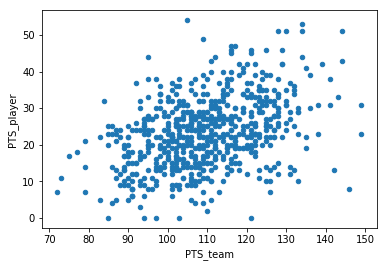

In [41]:
df_player_game['PTS_team'] = df_player_game['PTS_team'].astype(int)
df_player_game['PTS_player'] = df_player_game['PTS_player'].astype(int)

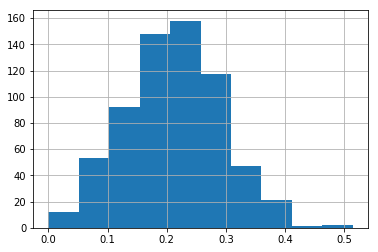

In [43]:
df_player_game['PTS_prop'] = df_player_game['PTS_player'].div(df_player_game['PTS_team'])
df_player_game['PTS_prop'].hist()

## Normality tests
The proportion and team points both like normal. Let's do some normality tests.

#### qq plot
Seems to look fairly normal from qq plot

Text(0.5,1,'PTS_prop qq plot')

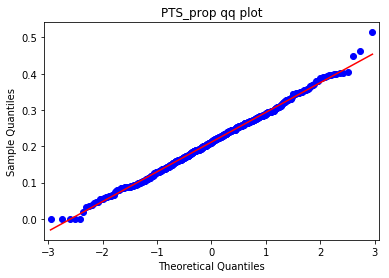

In [54]:
from statsmodels.graphics.gofplots import qqplot

qqplot(df_player_game['PTS_prop'], line='s')
plt.title('PTS_prop qq plot')

Text(0.5,1,'PTS_team qq plot')

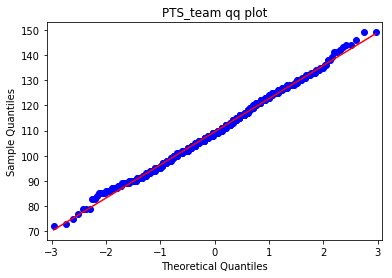

In [55]:
qqplot(df_player_game['PTS_team'], line='s')
plt.title('PTS_team qq plot')

#### Shapiro-Wilk test
Not reject normality

In [60]:
from scipy.stats import shapiro, anderson, normaltest

stat, p = shapiro(df_player_game['PTS_prop'])
print('PTS_prop p-value {:.4f}'.format(p))

stat, p = shapiro(df_player_game['PTS_team'])
print('PTS_team p-value {:.4f}'.format(p))

PTS_prop p-value 0.2924
PTS_team p-value 0.1028


#### Anderson Darling
Not reject normality

In [66]:
result = anderson(df_player_game['PTS_prop'])
print('PTS_prop statistic of {:.2f} with 5% critical value of {}'.format(result.statistic, result.critical_values[2]))

result = anderson(df_player_game['PTS_team'])
print('PTS_team statistic of {:.2f} with 5% critical value of {}'.format(result.statistic, result.critical_values[2]))


PTS_prop statistic of 0.31 with 5% critical value of 0.782
PTS_team statistic of 0.76 with 5% critical value of 0.782


# Independence
Test for independence between PTS_prop and PTS_team.

## Visual
Doesn't seem to be any obvious relationship. Maybe a slightly positive correlation.

In [84]:
import sklearn.linear_model

X = np.array(df_player_game['PTS_team']).reshape(-1, 1)
y = np.array(df_player_game['PTS_prop'])

lin_regr = sklearn.linear_model.LinearRegression(fit_intercept=True)
lin_regr.fit(X, y)

# Estimated parameters
print('Intercept {}'.format(lin_regr.intercept_))
print('Slope {}'.format(lin_regr.coef_))

Intercept 0.12676339072193332
Slope [ 0.0007768]


Text(0,0.5,'PTS_prop')

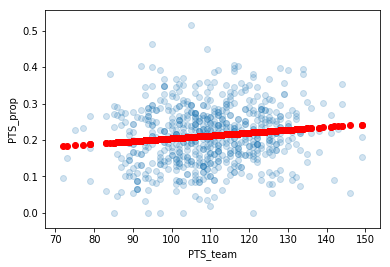

In [102]:
plt.scatter(x=X, y=y, alpha=0.2)
plt.scatter(x=X, y=lin_regr.predict(X), c='red')
plt.xlabel('PTS_team')
plt.ylabel('PTS_prop')

## Statistical tests

### Mutual information
Not really sure how to interpret this

In [97]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_regression(X, y)

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 0.10531083])

### Pearon's and spearman's correlation
Very weak but seems statistically significant

In [114]:
from scipy.stats import pearsonr, spearmanr

pearson_r, p_value_pearson = pearsonr(df_player_game['PTS_prop'], df_player_game['PTS_team'])
spearman_r, p_value_spearman = spearmanr(df_player_game['PTS_prop'], df_player_game['PTS_team'])

print('Pearons r {:.4f} p-value {:.4f}\nSpearman r {:.4f} p-value {:.4f}'.format(pearson_r, p_value_pearson,
                                                                                 spearman_r, p_value_spearman))

Pearons r 0.1250 p-value 0.0014
Spearman r 0.1213 p-value 0.0019
